In [43]:
import pandas as pd
import plotly.express as px
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
taxi = pd.read_csv("taxi.csv")

In [106]:
no_samples = 10000
random_state = 999

taxi_sample = taxi.sample(n = no_samples, random_state = random_state)

# converting the string to datetime format
taxi_sample['tpep_pickup_datetime'] = pd.to_datetime(taxi_sample['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_sample['tpep_dropoff_datetime'] = pd.to_datetime(taxi_sample['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_sample['trip_duration'] = taxi_sample['tpep_dropoff_datetime'] - taxi_sample['tpep_pickup_datetime']

# converting seconds to minutes
taxi_sample['trip_duration'] = taxi_sample['trip_duration'].apply(lambda x: round(x.total_seconds()/60,1))
taxi_sample.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
60887521         1  2015-05-11 19:22:39   2015-05-11 19:30:14   
830057           1  2015-01-02 07:02:08   2015-01-02 07:14:35   
34607052         2  2015-03-18 18:25:25   2015-03-18 18:34:01   
73247096         2  2015-06-21 09:04:26   2015-06-21 09:09:11   
56262042         1  2015-05-06 11:17:49   2015-05-06 11:23:37   

          passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
60887521                2           0.50        -73.975250        40.757019   
830057                  1           3.20        -73.979225        40.747192   
34607052                1           1.13        -73.997292        40.721779   
73247096                1           1.27        -73.991119        40.699501   
56262042                1           0.80        -73.982002        40.767082   

          RateCodeID store_and_fwd_flag  dropoff_longitude  dropoff_latitude  \
60887521           1                  N         -73.977280         40.762844   
830057             1                  N         -74.014282         40.715408   
34607052           1                  N         -73.999008         40.734249   
73247096           1                  N         -73.998863         40.694939   
56262042           1                  N         -73.995300         40.767044   

          payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
60887521             2          6.0    1.0      0.5        0.00           0.0   
830057               1         12.5    0.0      0.5        1.00           0.0   
34607052             1          7.5    1.0      0.5        1.86           0.0   
73247096             1          6.0    0.0      0.5        1.36           0.0   
56262042             2          6.0    0.0      0.5        0.00           0.0   

          total_amount  trip_duration  
60887521          7.80            7.6  
830057           14.30           12.4  
34607052         11.16            8.6  
73247096          8.16            4.8  
56262042          6.80            5.8

In [107]:
# removing any rows where no tips were paid
taxi_sample_tips = taxi_sample[taxi_sample["tip_amount"] != 0]

# checking the payment type
set(taxi_sample_tips["payment_type"].values.tolist())

{1}

In [108]:
px.scatter(taxi_sample_tips, x="trip_distance", y="tip_amount")

In [118]:
px.scatter(taxi_sample_tips[taxi_sample_tips['trip_duration'] < 100], x="trip_duration", y="tip_amount")

In [114]:
px.scatter(taxi_sample_tips, x="passenger_count", y="tip_amount")

In [109]:
# taking all rows where no tips were paid
taxi_sample_no_tips = taxi_sample[taxi_sample["tip_amount"] == 0]

# checking the payment type
set(taxi_sample_no_tips["payment_type"].values.tolist())

{1, 2, 3, 4}

In [110]:
# 1 = Credit card, 2 = Cash, 3 = No Charge, 4 = Dispute
no_tip_payment_counts = taxi_sample_no_tips["payment_type"].value_counts()
no_tip_payment_counts

2    3671
1     240
3      45
4      12
Name: payment_type, dtype: int64

<AxesSubplot:>

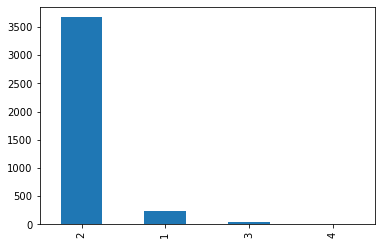

In [111]:
no_tip_payment_counts.plot(kind = "bar")

In [122]:
taxi_sample['tip'] = taxi_sample['tip_amount'].apply(lambda x: 0 if x == 0 else 1)

In [136]:
data_df = taxi_sample.drop(columns = ["VendorID", "tip", "tpep_pickup_datetime", "tpep_dropoff_datetime", "RateCodeID", "store_and_fwd_flag", "dropoff_longitude", "dropoff_latitude", "tip_amount"])
data = data_df.values
target = taxi_sample["tip"].values

In [137]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Specifying the number of features to take
no_features = 10

# Initialising the classifier with 100 estimators and fitting (training) the model with the data
rfi = RandomForestClassifier(n_estimators = 100)
rfi.fit(data, target)

# Sorts the importances from lowest to highest, reverses the order, and takes the 10 most important features
rfi_fs_indices = np.argsort(rfi.feature_importances_)[::-1][0:no_features]

# Taking the importance values of the top 10 features
rfi_feature_importances = rfi.feature_importances_[rfi_fs_indices]

# Determing the names of the top 10 most important features
rfi_best_features = data_df.columns[rfi_fs_indices].values
rfi_best_features

array(['payment_type', 'total_amount', 'fare_amount', 'trip_duration',
       'trip_distance', 'pickup_latitude', 'pickup_longitude', 'extra',
       'passenger_count', 'tolls_amount'], dtype=object)

Text(0, 0.5, 'Features')

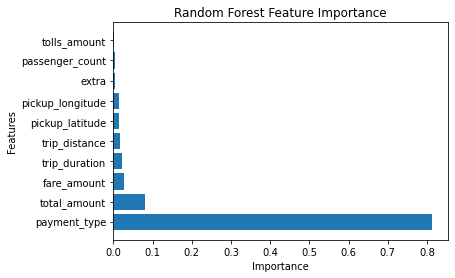

In [138]:
# Plotting a horizontal bar chart for the top 10 most important features
plt.barh(rfi_best_features, rfi_feature_importances)

# Setting the x + y axis labels and plot title
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")